# Writing a Molecular Monte Carlo Simulation

Starting today, make sure you have the functions

1. `calculate_LJ` - written in class
1. `read_xyz` - provided in class
1. `calculate_total_energy` - modified version provided in this notebook written for homework which has cutoff
1. `calculate_distance` - should be the version written for homework which accounts for periodic boundaries.
1. `calculate_tail_correction` - written for homework 


In [1]:
# add imports here
import math
import random
import matplotlib


In [ ]:
def calculate_total_energy(coordinates, box_length, cutoff):
    """
    Calculate the total energy of a set of particles using the Lennard Jones potential.
    
    Parameters
    ----------
    coordinates : list
        A nested list containing the x, y,z coordinate for each particle
    box_length : float
        The length of the box. Assumes cubic box.
    cutoff : float
        The cutoff length
    
    Returns
    -------
    total_energy : float
        The total energy of the set of coordinates.
    """
    
    total_energy = 0
    num_atoms = len(coordinates)

    for i in range(num_atoms):
        for j in range(i+1, num_atoms):
            # Calculate the distance between the particles - exercise.
            dist_ij = calculate_distance(coordinates[i], coordinates[j], box_length)

            if dist_ij < cutoff:
                # Calculate the pairwise LJ energy
                LJ_ij = calculate_LJ(dist_ij)

                # Add to total energy.
                total_energy += LJ_ij
    return total_energy

def read_xyz(filepath):
    """
    Reads coordinates from an xyz file.
    
    Parameters
    ----------
    filepath : str
       The path to the xyz file to be processed.
       
    Returns
    -------
    atomic_coordinates : list
        A two dimensional list containing atomic coordinates
    """
    
    with open(filepath) as f:
        box_length = float(f.readline().split()[0])
        num_atoms = float(f.readline())
        coordinates = f.readlines()
    
    atomic_coordinates = []
    
    for atom in coordinates:
        split_atoms = atom.split()
        
        float_coords = []
        
        # We split this way to get rid of the atom label.
        for coord in split_atoms[1:]:
            float_coords.append(float(coord))
            
        atomic_coordinates.append(float_coords)
        
    return atomic_coordinates, box_length

def calculate_LJ(r_ij):
    """
    The LJ interaction energy between two particles.

    Computes the pairwise Lennard Jones interaction energy based on the separation distance in reduced units.

    Parameters
    ----------
    r_ij : float
        The distance between the particles in reduced units.
    
    Returns
    -------
    pairwise_energy : float
        The pairwise Lennard Jones interaction energy in reduced units.

    Examples
    --------
    >>> calculate_LJ(1)
    0

    """
    
    r6_term = math.pow(1/r_ij, 6)
    r12_term = math.pow(r6_term, 2)
    
    pairwise_energy = 4 * (r12_term - r6_term)
    
    return pairwise_energy


def calculate_distance(coord1, coord2, box_length=None):
    """
    Calculate the distance between two points. When box_length is set, the minimum image convention is used to calculate the distance between the points.

    Parameters
    ----------
    coord1, coord2 : list
        The coordinates of the points, [x, y, z]
    
    box_length : float, optional
        The box length

    Returns
    -------
    distance : float
        The distance between the two points accounting for periodic boundaries
    """
    distance = 0
        
    for i in range(3):
        hold_dist = abs(coord2[i] - coord1[i])
    
        if (box_length):    
            if hold_dist > box_length/2:
                hold_dist = hold_dist - (box_length * round(hold_dist/box_length))
        distance += math.pow(hold_dist, 2)

    return math.sqrt(distance)

## Add your group's tail correction function

def calculate_tail_correction(num_particles, box_length, cutoff):
    """
    The tail correction associated with using a cutoff radius.
    
    Computes the tail correction based on a cutoff radius used in the LJ energy calculation in reduced units.
    
    Parameters
    ----------
    num_particles : int
        The number of particles in the system.
    
    box_length : int
        Size of the box length of the system, used to calculate volume.
    
    cutoff : int
        Cutoff distance.
    
    Returns
    -------
    tail_correction : float
        The tail correction associated with using the cutoff.
    """
    
    brackets = (1/3*math.pow(1/cutoff,9)) - math.pow(1/cutoff,3)
    volume = box_length**3
    
    constant = ((8*math.pi*(num_particles**2))/(3*volume))
    
    tail_correction = constant * brackets
    
    return tail_correction
    

The Metropolis Criterion
$$ P_{acc}(m \rightarrow n) = \text{min} \left[
		1,e^{-\beta \Delta U}
	\right] $$

In [ ]:
def accept_or_reject(delta_U, beta):
    """
    Accept or reject a move based on the Metropolis criterion.
    
    Parameters
    ----------
    detlta_U : float
        The change in energy for moving system from state m to n.
    beta : float
        1/temperature
    
    Returns
    -------
    boolean
        Whether the move is accepted.
    """
    if delta_U <= 0.0:
        accept = True
    else:
        #Generate a random number on (0,1)
        random_number = random.random()
        p_acc = math.exp(-beta*delta_U)
        
        if random_number < p_acc:
            accept = True
        else:
            accept = False
    return accept

In [ ]:
def calculate_pacc(delta_U, beta):
    """
    Accept or reject a move based on the Metropolis criterion.
    
    Parameters
    ----------
    detlta_U : float
        The change in energy for moving system from state m to n.
    beta : float
        1/temperature
    
    Returns
    -------
    boolean
        Whether the move is accepted.
    """
    
    return math.exp(-beta*delta_U)

In [ ]:
# Sanity checks - test cases
delta_energy = -1
beta = 1
accepted = accept_or_reject(delta_energy, beta)
assert accepted

In [ ]:
# Sanity checks - test cases
delta_energy = 0
beta = 1
accepted = accept_or_reject(delta_energy, beta)
assert accepted

In [ ]:
# To test function with random numbers
# can set random seed

#To set seed
random.seed(0)
random.random()

In [ ]:
delta_energy = 1
beta = 1
random.seed(0)
accepted = accept_or_reject(delta_energy, beta)
assert accepted is False

In [ ]:
#Clear seed
random.seed()

In [ ]:
def calculate_pair_energy(coordinates, i_particle, box_length, cutoff):
    """
    Calculate the interaction energy of a particle with its environment (all other particles in the system)
    
    Parameters
    ----------
    coordinates : list
        The coordinates for all the particles in the system.
        
    i_particle : int
        The particle number for which to calculate the energy.
        
    cutoff : float
        The simulation cutoff. Beyond this distance, interactions are not calculated.
    
    box_length : float
        The length of the box for periodic bounds
        
    Returns
    -------
    e_total : float
        The pairwise interaction energy of the ith particles with all other particles in the system
    """
    
    e_total = 0.0
    #creates a list of the coordinates for the i_particle
    i_position = coordinates[i_particle]
    
    num_atoms = len(coordinates)
    
    for j_particle in range(num_atoms):
        
        if i_particle != j_particle:
            #creates a list of coordinates for the j_particle
            j_position = coordinates[j_particle]
            rij = calculate_distance(i_position, j_position, box_length)
            
            if rij < cutoff:
                e_pair = calculate_LJ(rij)
                e_total += e_pair
    
    return e_total
    

In [ ]:
## Sanity checks
test_coords = [[0, 0, 0], [0, 0, 2**(1/6)], [0, 0, 2*2**(1/6)]]

# What do you expect the result to be for particle index 1 (use cutoff of 3)?
assert calculate_pair_energy(test_coords, 1, 10, 3) == -2
# What do you expect the result to be for particle index 0 (use cutoff of 2)?
assert calculate_pair_energy(test_coords, 0, 10, 2) == -1

assert calculate_pair_energy(test_coords, 0, 10, 3) == calculate_pair_energy(test_coords, 2, 10, 3)


# Monte Carlo Loop

In [ ]:
# Read or generate initial coordinates
coordinates, box_length = read_xyz('../../lj_sample_configurations/lj_sample_config_periodic1.txt')

# Set simulation parameters
reduced_temperature = 0.9
num_steps = 5000
max_displacement = 0.1
cutoff = 3
    #how often to print an update
freq = 1000

# Calculated quantities
beta = 1 / reduced_temperature
num_particles = len(coordinates)

# Energy calculations
total_energy = calculate_total_energy(coordinates, box_length, cutoff)
print(total_energy)
total_correction = calculate_tail_correction(num_particles, box_length, cutoff)
print(total_correction)
total_energy += total_correction


for step in range(num_steps):
    # 1. Randomly pick one of the particles.
    random_particle = random.randrange(num_particles)
    
    # 2. Calculate the interaction energy of the selected particle with the system.
    current_energy = calculate_pair_energy(coordinates, random_particle, box_length, cutoff)
    
    # 3. Generate a random x, y, z displacement.
    x_rand = random.uniform(-max_displacement, max_displacement)
    y_rand = random.uniform(-max_displacement, max_displacement)
    z_rand = random.uniform(-max_displacement, max_displacement)
    
    # 4. Modify the coordinate of Nth particle by generated displacements.
    coordinates[random_particle][0] += x_rand
    coordinates[random_particle][1] += y_rand
    coordinates[random_particle][2] += z_rand
    
    # 5. Calculate the interaction energy of the moved particle with the system and store this value.
    proposed_energy = calculate_pair_energy(coordinates, random_particle, box_length, cutoff)
    delta_energy = proposed_energy - current_energy
    
    # 6. Calculate if we accept the move based on energy difference.
    accept = accept_or_reject(delta_energy, beta)
    
    # 7. If accepted, move the particle.
    if accept:
        total_energy += delta_energy
    else:
        #Move not accepted, roll back coordinates
        coordinates[random_particle][0] -= x_rand
        coordinates[random_particle][1] -= y_rand
        coordinates[random_particle][2] -= z_rand
    
    # 8. Print the energy if step is a multiple of freq.
    if step % freq == 0:
        print(step, total_energy/num_particles)

# Visualization

In [22]:
import matplotlib.pyplot as plt


# special jupyter notebook command to make plots interactive
%matplotlib notebook

<IPython.core.display.Javascript object>


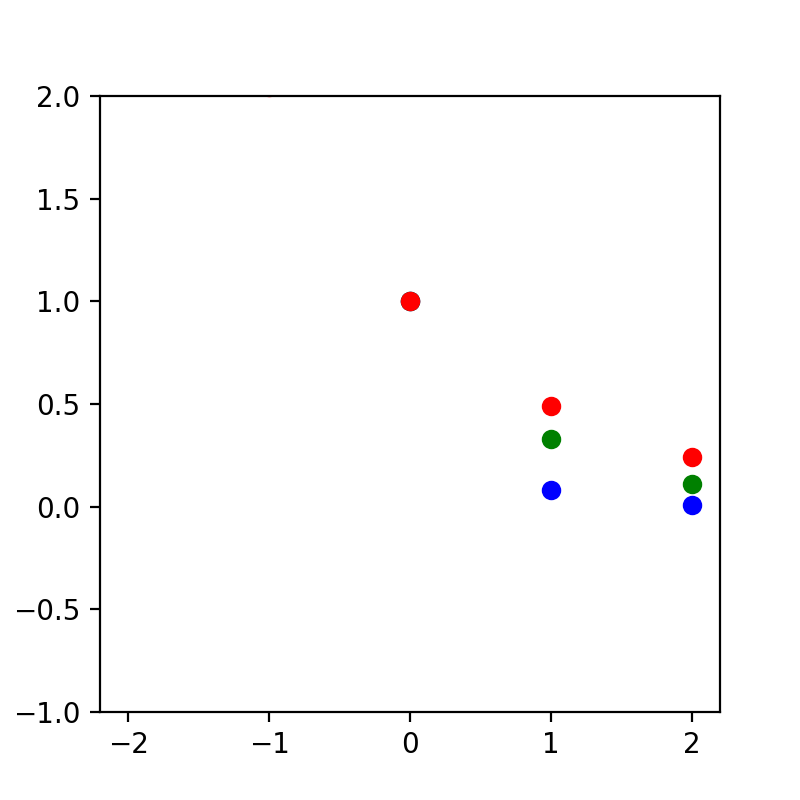

(-1.0, 2.0)

In [29]:
# Create plots
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_ylim([-1, 2])
#ax.legend([line1, line2, line3], ['T=0.4', 'T=0.9', 'T=1.4'])

In [30]:
# Sanity checks - test cases


#accepted = accept_or_reject(delta_energy, beta)


def test_pacc():
    ts = [0.4, 0.9, 1.4]
    colors = ['ob', 'og', 'or']
    
    
    count = 0
    for t in ts:
        for i in range(-2, 3):
            #print(i)
        
            beta = 1/t
            y = math.exp(-beta*i)
            #print(y)
            color = colors[count]
            ax.plot(i,y, color)
        count += 1
            
    
test_pacc()   


# Exploring the Acceptance Criteria?
What is the effect of temperature on the probability of a MC move being accepted?
As temperature increases then probability of aceptance increases

In [41]:
def system_init(n_particles, volume):
    """
    Sets up initial system configurations from a number of particles and box size 
     
    Parameters
    ----------
    n_particles : int
        Number of particles.
    
    volume : float
        Volume of the box
        
    Return
    ------
    coordinates : list of tuples
        Coordinates created
        
    box_length : float
        Calculated box length
        
    """
    coordinates = []
    box_length = volume**(1/3)
    
    for p in range(n_particles):
        x = random.uniform(-box_length/2, box_length/2)
        y = random.uniform(-box_length/2, box_length/2)
        z = random.uniform(-box_length/2, box_length/2)
        coordinates.append((x,y,z))
        
    
    return coordinates, box_length

In [43]:
n_particles = 800
coordinates, box_length = system_init(n_particles, 512)
print(box_length)

assert len(coordinates) == n_particles
print(coordinates)

7.999999999999999
[(2.0859353081542724, 1.7185271759414182, -1.2438179310123383), (-2.719514289218468, -2.6654832197946234, -1.845298129103817), (-0.6463328107185955, -1.3600625363524177, 3.9474344423524905), (2.6954895014046696, 0.41066566803235416, -2.9621048388549287), (-0.3511663059985475, -0.09244846239556459, 3.878168973006422), (0.04316122360584762, 1.8860918994585165, -0.3941624220829736), (2.8196070973700427, -0.3587762447669043, -1.6084079648556218), (2.5315628366157727, 0.834591904040376, 1.4718385657288082), (3.868291775604629, 0.22944553561420156, -1.1650354163741437), (-1.262789022690331, 0.8626226326303956, -0.35675414689667573), (-2.3142400422401845, 0.419898673832781, -1.270095342481552), (-0.7118436750739381, -0.3523244065882256, 1.503110761349204), (2.704251945432135, -0.19607566430579304, 0.8736927575316948), (0.37365736628213275, -0.059850397568939506, 0.5864920997629768), (-2.508738536264512, 3.341468670796728, 3.2860652116839346), (-0.20252886466962483, 3.8941846